# Changelog

## Season 1, Episode 01
...

## Season 1, Episode 02
...

## Season 1, Episode 03
...

## Season 1, Episode 04

Tue May  4 21:09:45 CEST 2021

Finished adding ContentLoss and StyleLoss layers in the model.

Thus, we've completed the model \o/


## Season 1, Episode 05

Thu May 20 19:53:52 CEST 2021



In [1]:
import numpy as np

In [2]:
import torch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(DEVICE)

In [3]:
PIC_SIZE = 512 if torch.cuda.is_available() else 128

In [4]:
from torchvision import transforms

loader = transforms.Compose([
    transforms.Resize(PIC_SIZE),
    transforms.ToTensor(),
])

In [5]:
from PIL import Image

krakow = Image.open("./pics/krakow.jpg")
picasso = Image.open('./pics/picasso.jpg')

In [6]:
npkrakow = np.array(krakow)
krakowtensor = torch.Tensor(npkrakow)

krakowloaded = loader(krakow)
krakowtensor.shape

torch.Size([213, 213, 3])

In [7]:
cztery = krakowloaded.unsqueeze(0)
cztery = cztery.to(device, dtype=torch.float)

In [8]:
def imgloader(fp) -> torch.Tensor:
    img = Image.open(fp)
    loaded = loader(img) 
    loaded = loaded.unsqueeze(0)  # [..., np.newaxis]
    loaded_with_device = loaded.to(device, dtype=torch.float)
    return loaded_with_device

In [9]:
picasso = imgloader('./pics/picasso.jpg')
krakow = imgloader('./pics/krakow.jpg')
krakow.shape

torch.Size([1, 3, 128, 128])

In [10]:
unloader = transforms.ToPILImage()

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.ion()
picasso.shape

torch.Size([1, 3, 128, 128])

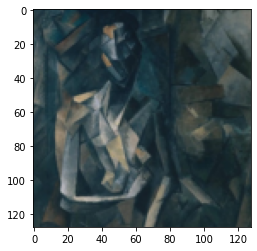

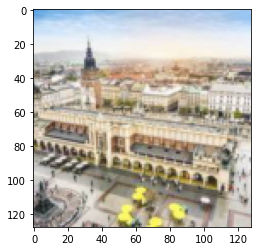

In [12]:
def showtensor(tensor: torch.Tensor) -> None:
    tensor = tensor.cpu().clone()
    unloaded = unloader(tensor.squeeze(0))
    plt.figure()
    plt.imshow(unloaded)
    
showtensor(picasso)
showtensor(krakow)

In [13]:
## pytorch module
import torch.nn as nn
import torch.nn.functional as F

# Ltotal(~p,~a,~x) =αLcontent(~p,~x) +βLstyle(~a,~x)

class ContentLoss(nn.Module):
    
    def __init__(self, p: torch.Tensor):
        nn.Module.__init__(self)
        self.p = p
        self._loss = None
        
    def forward(self, x) -> torch.Tensor:
        # Lcontent(→p,→x, l) = 1/2 ∑ i,j (Flij − Plij)².
        # return .5 * sum((x - p)**2)
        self._loss = F.mse_loss(x, self.p)
        return x

# t1 = torch.Tensor([2, 2])
# t2 = torch.Tensor([4, 4])
# ContentLoss(t1).forward(t2)

In [14]:
def gram(t: torch.Tensor) -> torch.Tensor:
    a, b, c, d = t.size()
    g = t.view(a*c, b*d)
    return g @ g.T / (a*b*c*d)
    
gram(picasso)

class StyleLoss(nn.Module):
    
    def __init__(self, p: torch.Tensor):
        nn.Module.__init__(self)
        self.p = gram(p).detach()
        self._loss = None
        
    def forward(self, x) -> torch.Tensor:
        # Lstyle(~a,~x) = ∑ wl E
        self._loss = F.mse_loss(gram(x), self.p)
        return x
    
StyleLoss(picasso).forward(krakow)

tensor([[[[0.3490, 0.3451, 0.3490,  ..., 0.6196, 0.6235, 0.6314],
          [0.3647, 0.3725, 0.3804,  ..., 0.6118, 0.6118, 0.6118],
          [0.3843, 0.3922, 0.4078,  ..., 0.6118, 0.6118, 0.6157],
          ...,
          [0.4196, 0.4824, 0.5451,  ..., 0.8353, 0.8196, 0.8157],
          [0.4588, 0.4275, 0.3843,  ..., 0.8353, 0.8196, 0.8196],
          [0.7333, 0.5725, 0.5490,  ..., 0.8314, 0.8196, 0.8235]],

         [[0.6196, 0.6157, 0.6157,  ..., 0.7804, 0.7804, 0.7882],
          [0.6353, 0.6392, 0.6471,  ..., 0.7804, 0.7765, 0.7765],
          [0.6471, 0.6510, 0.6667,  ..., 0.7804, 0.7843, 0.7882],
          ...,
          [0.3843, 0.4471, 0.5098,  ..., 0.8118, 0.7961, 0.7922],
          [0.4235, 0.3922, 0.3490,  ..., 0.8078, 0.7922, 0.7922],
          [0.6980, 0.5373, 0.5137,  ..., 0.8039, 0.7922, 0.7961]],

         [[0.8745, 0.8706, 0.8627,  ..., 0.9412, 0.9412, 0.9451],
          [0.8902, 0.8941, 0.8941,  ..., 0.9412, 0.9412, 0.9412],
          [0.8980, 0.9020, 0.9059,  ..., 0

In [15]:
from torchvision.models import vgg19

foo = vgg19(pretrained=True, progress=True)
network = foo.features.to(device).eval()

In [16]:
class Normalisation(nn.Module):
    def __init__(self):
        self.cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
        self.cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
        
    def forward(self, x):
        return (x - self.cnn_normlization_mean) / self.cnn_normlization_std

In [17]:
model = nn.Sequential()
conv_counter = 0
style_losses, content_losses = [], []
for n, x in network.named_children():        

    
    if isinstance(x, nn.ReLU):
        model.add_module(name=n, module=nn.ReLU(inplace=False))
        
    elif isinstance(x, nn.Conv2d):
        # 4 -> Content
        # 1,2,3,4,5 -> Style
        
        conv_counter += 1
        print(n, conv_counter)

        model.add_module(name=n, module=x)
        
        if conv_counter == 4:
            # print("CONTENT")
            p_l  = model(krakow).detach()
            content_loss = ContentLoss(p_l)
            model.add_module(name="ContentLoss", module=content_loss)
            content_losses.append(content_loss)
            max_content = n
            
        if conv_counter in [1,2,3,4,5]:
            # print("STYLE")
            a_l  = model(picasso).detach()
            style_loss = StyleLoss(a_l)
            model.add_module(name=f"StyleLoss{n}_{conv_counter}", module=style_loss)
            style_losses.append(style_loss)
            max_style = n
            
            # NOTE: this works because it's bigger than '4' in Content xD
            if conv_counter == 5:
                break

    else:
        model.add_module(name=n, module=x)

model

0 1
2 2
5 3
7 4
10 5


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (StyleLoss0_1): StyleLoss()
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (StyleLoss2_2): StyleLoss()
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (StyleLoss5_3): StyleLoss()
  (6): ReLU()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ContentLoss): ContentLoss()
  (StyleLoss7_4): StyleLoss()
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (StyleLoss10_5): StyleLoss()
)

In [18]:
krakows = []

In [25]:
def weighted_sum(styles, contents):
    style = sum(s._loss for s in styles)
    content = sum(c._loss for c in contents)
    
    return style * 10e6 + content * 1


# w = weighted_sum(style_losses, content_losses)

whatever = 10

optimizer = torch.optim.LBFGS([krakow.requires_grad_()])
optimizer

for _ in range(whatever):
    
    def closure():
        krakow.data.clamp_(0, 1)
        optimizer.zero_grad()
        output = model(krakow)
        loss = weighted_sum(style_losses, content_losses)
        print(loss)
        loss.backward()
        return loss
    
    optimizer.step(closure)
    krakow.data.clamp_(0, 1)
    
krakows.append(krakow.clone().detach())

tensor(22.0448, grad_fn=<AddBackward0>)
tensor(22.0872, grad_fn=<AddBackward0>)
tensor(22.0345, grad_fn=<AddBackward0>)
tensor(22.0313, grad_fn=<AddBackward0>)
tensor(22.0161, grad_fn=<AddBackward0>)
tensor(22.0064, grad_fn=<AddBackward0>)
tensor(21.9911, grad_fn=<AddBackward0>)
tensor(21.9841, grad_fn=<AddBackward0>)
tensor(21.9760, grad_fn=<AddBackward0>)
tensor(21.9683, grad_fn=<AddBackward0>)
tensor(21.9608, grad_fn=<AddBackward0>)
tensor(21.9484, grad_fn=<AddBackward0>)
tensor(21.9314, grad_fn=<AddBackward0>)
tensor(21.9167, grad_fn=<AddBackward0>)
tensor(21.9055, grad_fn=<AddBackward0>)
tensor(21.8915, grad_fn=<AddBackward0>)
tensor(21.8781, grad_fn=<AddBackward0>)
tensor(21.8588, grad_fn=<AddBackward0>)
tensor(21.8409, grad_fn=<AddBackward0>)
tensor(21.8273, grad_fn=<AddBackward0>)
tensor(21.8022, grad_fn=<AddBackward0>)
tensor(21.7856, grad_fn=<AddBackward0>)
tensor(21.7603, grad_fn=<AddBackward0>)
tensor(21.7482, grad_fn=<AddBackward0>)
tensor(21.7349, grad_fn=<AddBackward0>)


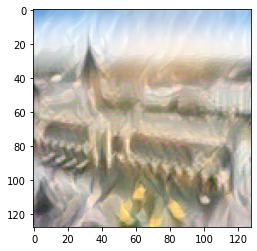

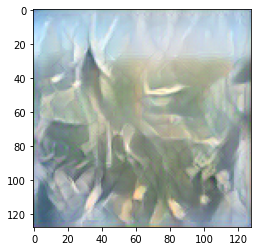

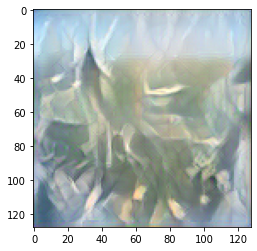

In [24]:
for krk in krakows:
    showtensor(krk)